# Example: Runtime comparisons

- This example explains the experiments for the runtime comparisons section. We solve the same objective function using different algorithms, and compare their runtimes. 
- We first explain the codes to be used in this example. These include the codes for the coordinate descent (CD), interior point (IP) and ADMM methods. 

#### Codes for algorithms (implicitly used in this example):
1. Coordinate Descent (CD):
    - The function `CGD(X,y, Gamma, lambda1, lambda2, eps = 1e-4, max_it = 50000)` takes in:
       - `X` as the design matrix of size $n \times p$
       - `y` as the response vector of length $n$
       - `Gamma` as the incidence matrix of the given graph $G$
       - `lambda1` as the $\lambda_1$ in $\lambda_1 \|\Gamma \beta\|_1$
       - `lambda2` as the $\lambda_2$ in $\lambda_2 \|\Gamma \beta\|_2^2$
       - `eps` as the tolerance for stopping criterion, with default value `eps = 1e-4`
       - `max_it` as the maximum number of iterations allowed for the algorithm
    - The function `GCD` returns the estimation $\hat{\beta}$ as an array of size $p$
    - The dual vector $u$ is initialized to an array of all zeros, as described in the paper.


2. Interior Point (IP):
    - The function `IP(X,y, Gamma, lambda1, lambda2, tau = 1.5, eps = 1e-4, max_it = 10000)` takes in:
        - `X`, `y`, `Gamma`, `lambda1`, `lambda2`, `eps`, `max_it` the same as the function `CGD`
        - `tau` as the factor which $t$ increased by in each iteration, as described in the paper. Here, the default choice is `tau = 1.5`.
    - The function `IP` returns the estimation $\hat{\beta}$ as an array of size $p$.
    - The dual vector $u$ is initialized to an array of all zeros. $\mu_1$ and $\mu_2$ are initialized to arrays of all $10$s, which are just an arbitrary choice to satisfy $\mu_1 > 0$ and $\mu_2 > 0$.
    - The $\alpha, \gamma$ backtracking line search is done by the function `line_search(..., a = 0.1, b = 0.7)`, where the default values of $(\alpha, \gamma)$ are $(0.1, 0.7)$ 



3. ADMM:
    - The function `Gauss_ADMM(X, y, Gamma, lambda1, lambda2, rho = 1, eps = 1e-3, max_it = 50000)` takes in:
         - `X`, `y`, `Gamma`, `lambda1`, `lambda2`, `eps`, `max_it` the same as the function `CGD`
             - Note that for this section, the default tolerance is `eps = 1e-3` instead. 
         - `rho` is  the Lagrangian augmentation factor; equivalently the step-size for dual ascent. Here, its default value is set to $1$. For discussions on its influence on convergence speed, see Boyd et al. (2010).
    - The function `Gauss_ADMM` returns the estimation $\hat{\beta}$ as an array of size $p$
  
  
  
4. ECOS(CVXPY):
    - Here, we simply call the functions for estimators written in `estimators.py`, which use ECOS algorithm in CVXPY package to solve for the signal estimations.

#### Import functions:

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
import numpy.linalg as la
import networkx as nx

from estimators import *
from signals import *


#### Functions from `signals.py` that will be used for this section:

- The function `gauss_sample(n, p, beta_star, Psi, sigma, set_seed = 1)` returns a randomly generated data set `X, y` according to $y = X \beta^* + \epsilon$.
    - `n`: number of observations for this data set
    - `p` (redundant): length of `beta_star` 
    - `beta_star`: a **1D** array that represents $\beta^*$
    - `sigma`: The noise $\sigma$ for $\epsilon$ drawn i.i.d. from $N(0, \sigma^2)$
    - `Psi`: Corresponds to the covariance matrix $\Psi$. Rows of `X` are drawn i.i.d. from $N(0, \Psi)$
    - `set_seed`: used to set seed for the random generation.



-  The function `smooth_stair(slope_length, slope_height, step_length, start_value, n_repeat)` returns a 1D array that corresponds to a signal indexed by a 1D chain graph. 
    - It returns a signal whose values contains multiple smooth increasing parts and flat parts (looks like a stair).
    - `slope_length` is the number of nodes in the increasing part, `slope height` is the total increase of values in the increasing part. `step_length` is the number of nodes in the flat part. The signal consists of `n_repeat` number of 'step'+'slope' structures. `start_value` is simple the minimum value of the signal.
    
    
- The function `smooth_2d(side_len, disk_radi, period, height, start_value)` returns a ***2D*** array that corresponds to a signal indexed by a 2D grid graph. 
    - Use `.flatten()` to turn this 2D array output to a 1D array. Then we can use this 1D array as input for `gauss_sample`
    - It returns a signal whose values contain a flat disk in the middle of the 2D grid, and smoothly decrease. 
    - `side_len` is the side length (number of nodes on one side) of the 2D grid graph (for symmetry consideration, we always use an odd number of nodes). `disk_radi` is the radius of the flat disk in terms of number of nodes. `period` describes how fast the values decrease sinusoidally (larger period gives slower decrease). Again, `start_value` is the minimum value, the disk part has value `start_value` + `height`
    
    
    
- `chain_incidence(p)` returns the incidence matrix of a 1D chain graph with $p$ nodes as a 2D array.
- `grid_incidence(a)` returns the incidence matrix of a 2D grid graph with $a \times a$ nodes as a 2D array.
- `cor_from_G(G, a)` takes in a graph object G and returns the correlation matrix constructed from $(L+ aI)^{-1}$ (For 2D grid case)
    - We choose `a` $ = 0.5$ for following experiments.
- `toeplitz(a, p)` returns the toeplitz covariance matrix with factor `a` and size $p \times p$ (For 1D chain case)
    - We choose `a` $ = 0.5$ for following experiments.
#### Functions from `estimators.py` that will be used for this section:

- `GEN(l1 = 0, l2 = 0, D = 0)` returns an estimator object initialized with $\lambda_1 = $ `l1`, $\lambda_2 = $ `l2`  , and incidence matrix $\Gamma = $ `D`. The default values are $0$.
    - Its method `fit(self, X, y)` returns a fitted estimator whose attribute `beta` is the fitted $\hat{\beta}$
    - The algorithm used for this fitting method is ECOS with `abstol = 1e-4`.

- `GEN_CGD` uses Coordinate Descent (CD) as its fitting method. `GEN_IP` uses Interior Point method (IP) as its fitting method. `GEN_ADMM` uses ADMM as its fitting method. Default settings of the 3 methods have been described before.

### Experiment design:
- Observe how runtime grows with respect to scaling of size of the signal $p$, while number of obervations $n$ is fixed. 
    - Here, we can simply fix $n = 2000$. Try $p = 200, 400$ for 1D chain case, and $p = 15 \times 15, 19 \times 19$ for 2D grid case to get a rough sense.
    - We used `smooth_stair` and `smooth_2d` to construct signals of different size $p$
- Fix the noise $\sigma = 1$
- $\lambda_1, \lambda_2$ can be chosen by cross validation or by theory. Here, for convenience, we can simply try $\lambda_1, \lambda_2$ = $25, 10$.


In [16]:
n = 2000
sigma = 1

#### 1. 1D Chain graph
- (a) $p = 200$   
- (b) $p = 400$

In [8]:
### construct signals
beta_1d_a = smooth_stair(10, 5, 20, 0, 30)[0:200]   
beta_1d_b = smooth_stair(10, 5, 20, 0, 30)[0:400]

### construct covariance matrices
Psi_a = toeplitz(0.5, 200)
Psi_b = toeplitz(0.5, 400)

### generate data
X_a, y_a = gauss_sample(n, 200, beta_1d_a, Psi_a, sigma, 1)
X_b, y_b = gauss_sample(n, 400, beta_1d_b, Psi_b, sigma, 2)

### construct the incidence matrices:
D_a = chain_incidence(200)
D_b = chain_incidence(400)

### iterate through the 4 algorithms. Record the runtime using time.time()

runtimes_a = []
runtimes_b = []


for est in [GEN, GEN_CGD, GEN_IP, GEN_ADMM]:
    start_time = time.time()
    est(25, 10, D_a).fit(X_a, y_a)  #l1 = 25, l2 = 10 is just a choice for simplicity
    runtimes_a.append(time.time() - start_time)
    
    start_time = time.time()
    est(25, 10, D_b).fit(X_b, y_b)   # repeat for (b)
    runtimes_b.append(time.time() - start_time)

#### We can visualize the runtimes by plotting:

In [9]:
ps = [200, 400]
ecos_time, cd_time, ip_time, admm_time = list(zip(runtimes_a, runtimes_b))


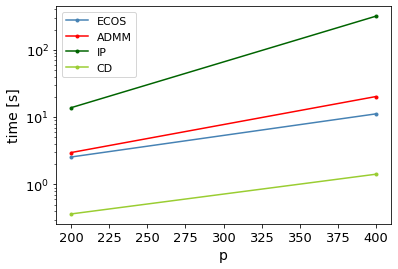

In [10]:
plt.plot(ps,ecos_time, color = 'steelblue', marker = '.', label = 'ECOS')
plt.plot(ps, admm_time, color = 'red', marker = '.', label = 'ADMM')
plt.plot(ps, ip_time,  marker = '.',color = "darkgreen", label = 'IP')
plt.plot(ps, cd_time , color = 'yellowgreen', marker = '.', label = 'CD')
plt.ylabel('time [s]', size = 14)
plt.xlabel('p', size = 14)
plt.yscale('log')  ### log scale is used since some runtimes are much larger than others
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.legend(fontsize = 11)

#### 2. 2D grid graph
- (a) $p = 15 \times 15 = 225$
- (b) $p = 19 \times 19 = 361$
- We are mostly repeating the procedures in 1., with slight modifications.
- runtimes for the interior point (IP) method is not recorded here. Sometimes it is very slow. Partially because `IP` uses the dense incidence matrix `Gamma` for matrix multiplications, which is not optimized at all.

In [39]:
### construct signals
beta_2d_a = smooth_2d(15,1, 7, 3, 5).flatten()
beta_2d_b = smooth_2d(19,1.25, 8.75, 3.75, 5).flatten()


### construct covariance matrices
G_a =  nx.grid_graph(dim = (15,15)) ## first create graph objects
G_b =  nx.grid_graph(dim = (19,19))
 
Psi_a = cor_from_G(G_a, 0.5)  ## then use cor_from_G to output covariance matrices
Psi_b = cor_from_G(G_b, 0.5)

### generate data
X_a, y_a = gauss_sample(n, 225, beta_2d_a, Psi_a, sigma, 3)
X_b, y_b = gauss_sample(n, 361, beta_2d_b, Psi_b, sigma, 4)

### construct the incidence matrices:
D_a = grid_incidence(15)
D_b = grid_incidence(19)


In [40]:
### iterate through GEN, GEN_CGD, GEN_ADMM (GEN_IP is very slow sometimes). Record the runtime using time.time()

runtimes_a = []
runtimes_b = []


for est in [GEN, GEN_CGD, GEN_ADMM]:
    start_time = time.time()
    est(25, 10, D_a).fit(X_a, y_a)  
    runtimes_a.append(time.time() - start_time)
    
    start_time = time.time()
    est(25, 10, D_b).fit(X_b, y_b)   # repeat for (b)
    runtimes_b.append(time.time() - start_time)


#### Again, we plot the results:

In [41]:
ps = [225, 361]
ecos_time, cd_time, admm_time = list(zip(runtimes_a, runtimes_b))

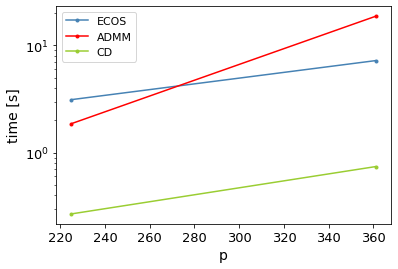

In [42]:
plt.plot(ps,ecos_time, color = 'steelblue', marker = '.', label = 'ECOS')
plt.plot(ps, admm_time, color = 'red', marker = '.', label = 'ADMM')
plt.plot(ps, cd_time , color = 'yellowgreen', marker = '.', label = 'CD')
plt.ylabel('time [s]', size = 14)
plt.xlabel('p', size = 14)
plt.yscale('log')  ### log scale is used since some runtimes are much larger than others
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.legend(fontsize = 11)

#### Note that different choices of $\lambda_1, \lambda_2$ and signals can greatly influence the runtimes. 
- choices of tolerance, default $\rho, \alpha, \gamma$ values for algorithms (as discussed before) may also make big difference.

#### In general, CD scales better than other algorithms. 